In [4]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.linear_model import Lasso

In [5]:
# Reset PN sequence generator.
seed = 42
np.random.seed()

In [6]:
def generateDatasets(N):

    # Create target function and its noisy version.
    x_train = np.sort(6.0*np.random.rand(N, 1) - 3.0, axis=0)
    y_train = 0.5*x_train**2 + x_train + 2
    y_train_noisy = y_train + np.random.randn(N, 1)

    # Create a validation dataset.
    N = 50
    x_test = np.linspace(-3.0, 3.0, N).reshape(N, 1)
    y_test = 0.5*x_test**2 + x_test + 2
    y_test_noisy = y_test + np.random.randn(N, 1)
    
    return x_train, y_train, y_train_noisy, x_test, y_test_noisy

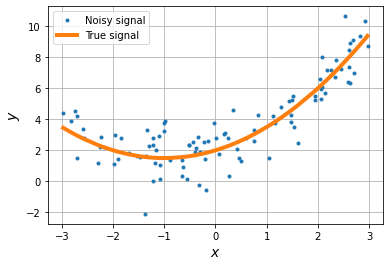

In [7]:
# Number of examples.
N = 100

# Generate dataset.
x_train, y_train, y_train_noisy, x_test, y_test_noisy = generateDatasets(N)

# Plot comparison between true and noisy model.
plt.plot(x_train, y_train_noisy, '.', label='Noisy signal')
plt.plot(x_train, y_train, label='True signal', linewidth=4)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.grid()
plt.legend()
plt.show()

### Chosen degree

In [8]:
chosen_degree = 30

### Polinomial regression without regularization.

score: 0.8445786512003519
MSE: 1.0231627801589631


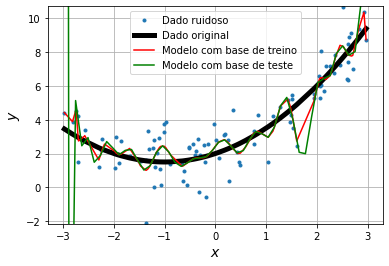

In [10]:
# Define paramater to include bias.
include_bias = True

# Instantiate a polynomial.
poly = PolynomialFeatures(degree=chosen_degree, include_bias=include_bias)
# Instantiate a scaler.
scaler = StandardScaler()
# Instantiate a linear regressor.
reg = LinearRegression()

# Create a pipeline of actions.
poly_reg = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Train the model with the ideal order.
poly_reg.fit(x_train, y_train_noisy.ravel())

# Predict using the trained model.
y_pred_train = poly_reg.predict(x_train)
y_pred_test = poly_reg.predict(x_test)

print('score:',poly_reg.score(x_train, y_train_noisy))
print('MSE:',mean_squared_error(y_pred_train, y_train_noisy))

# Plot original data versus noisy version and predicted version.
plt.plot(x_train, y_train_noisy, '.', label='Dado ruidoso')
plt.plot(x_train, y_train, 'k', label='Dado original', linewidth=5)
plt.plot(x_train, y_pred_train, 'r', label='Modelo com base de treino')
plt.plot(x_test, y_pred_test, 'g', label='Modelo com base de teste')
plt.ylim(min(y_train_noisy)-0.05, max(y_train_noisy)+0.05)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()

# Show the plot.
plt.show()

### Logaritmic search.

In [12]:
# Digite o código do exercício aqui.

# Number of lambda values.
M = 1000
lambdas = np.logspace(-10, 2, M)

# Instantiate empty vectors.
a_hist = np.zeros((chosen_degree, M)) if include_bias == False else np.zeros((chosen_degree+1, M))
norm_hist = np.zeros((1, M))
error_train = []
error_test = []

# Iterate over all lambda values.
for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=chosen_degree, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], max_iter=5000, tol=1e-1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    
    # Train model.
    model.fit(x_train, y_train_noisy)    

    # Store weights.
    a_hist[:,i] = model.named_steps['reg'].coef_
    a_hist[0,i] = model.named_steps['reg'].intercept_

    # Normalize weight vector.
    norm_hist[:,i] = np.linalg.norm(a_hist[:,i])
    
    # Predict with train set.
    y_pred_train = model.predict(x_train)
    error_train.append(mean_squared_error(y_train_noisy, y_pred_train))       
    
    # Predict with test set.
    y_pred_test = model.predict(x_test)
    error_test.append(mean_squared_error(y_test_noisy, y_pred_test))
    
idx_log = np.argmin(error_test)
lambda_opt_log = lambdas[idx_log]
print('Best lambda:', lambda_opt_log)

Best lambda: 0.058717663907332615


### Plotting results

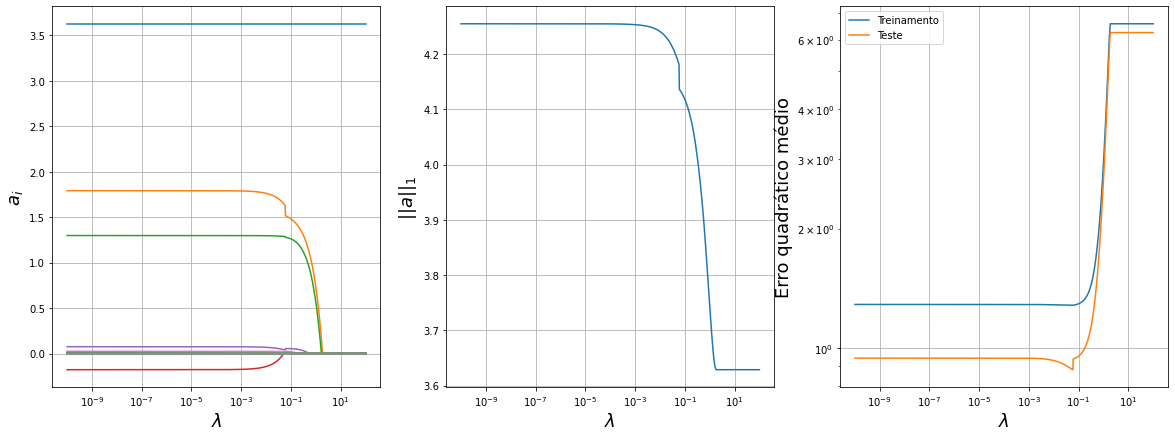

In [13]:
# Digite o código do exercício aqui.

# Plot results.
fig = plt.figure(figsize=(20,7))

# Plot weights.
ax = plt.subplot(1, 3, 1)
for i in range(0,chosen_degree): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_1$', fontsize=18)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_train, label='Treinamento')
plt.plot(lambdas, error_test, label='Teste')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio', fontsize=18)
plt.grid()
plt.legend()

#Show the plot.
plt.show()

### Fine-tuning $\lambda$

In [14]:
# Number of lambda values.
M = 1000
lambdas = np.linspace(lambda_opt_log/10, lambda_opt_log*10, M)

# Instantiate empty vectors.
a_hist = np.zeros((chosen_degree, M)) if include_bias == False else np.zeros((chosen_degree+1, M))
norm_hist = np.zeros((1, M))
error_train = []
error_test = []

# Iterate over all lambda values.
for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=chosen_degree, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], max_iter=5000, tol=1e-3, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    
    # Train model.
    model.fit(x_train, y_train_noisy)    

    # Store weights.
    a_hist[:,i] = model.named_steps['reg'].coef_
    a_hist[0,i] = model.named_steps['reg'].intercept_

    # Normalize weight vector.
    norm_hist[:,i] = np.linalg.norm(a_hist[:,i])
    
    # Predict with train set.
    y_pred_train = model.predict(x_train)
    error_train.append(mean_squared_error(y_train_noisy, y_pred_train))       
    
    # Predict with test set.
    y_pred_test = model.predict(x_test)
    error_test.append(mean_squared_error(y_test_noisy, y_pred_test))

idx = np.argmin(error_test)
lambda_opt = lambdas[idx]
print('Best lambda:', lambda_opt)

Best lambda: 0.03612987788171908


### Comparing results

score: 0.8445786512003519
MSE: 1.2767355128425948


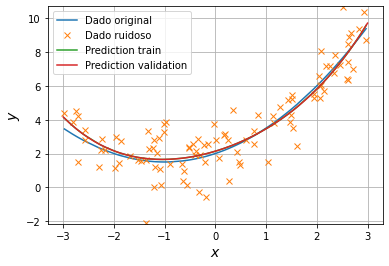

In [16]:
# Digite o código do exercício aqui.

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=chosen_degree, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = Lasso(alpha=lambda_opt, max_iter=5000, tol=1e-5, random_state=seed)
# Create a pipeline of actions.
model = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])
# Train model.
model.fit(x_train, y_train_noisy)

# Predict.
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

print('score:',poly_reg.score(x_train, y_train_noisy))
print('MSE:',mean_squared_error(y_pred_train, y_train_noisy))

# Plot figure.
plt.plot(x_train, y_train, label='Dado original')
plt.plot(x_train, y_train_noisy, 'x', label='Dado ruidoso')
plt.plot(x_train, y_pred_train, label='Prediction train')
plt.plot(x_test, y_pred_test, label='Prediction validation')
plt.ylim(min(y_train_noisy)-0.05, max(y_train_noisy)+0.05)
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)
plt.grid()
plt.legend()
plt.show()

### Feature importance

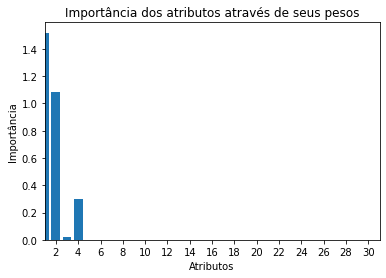

In [17]:
importance = np.abs(model.named_steps['reg'].coef_)
plt.bar(height=importance, x=range(0,chosen_degree+1))
plt.title("Importância dos atributos através de seus pesos")
plt.xlabel('Atributos')
plt.ylabel('Importância')
plt.xticks(range(0,chosen_degree+1,2))
plt.xlim(1,chosen_degree+1)
plt.show()